# Artificial Intelligence
# 464
# Project #5

## Before You Begin...
00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, and
02.  Check the submission deadline on Gradescope.


## General Directions for this Assignment
00. Output format should be exactly as requested,
01. Functions should do only one thing,
02. Keep functions to 20 lines or less (empty lines are fine, there's leeway, but don't blatantly ignore this),
03. Add docstring to all functions,


## Before You Submit...
00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.

## Decision Trees

For this assignment we will implement a Decision Tree using the ID3 Algorithm. The goal is classify a mushroom as either edible ('e') or poisonous ('p') using the same dataset as Project #5.


Our  Decision Tree pipeline is as follows:


1) `cross_validate` will take data (supplied as folds using 10 fold cross validation) and do the following:
* For each setting of depth limit (the hyperparameter in decision trees, including 0)
* * and for each fold of data
* * * use `create_train_test` to split current fold into train and test
* * * call `train` to build and return a decision tree, 
* * * call `classify` to use the tree to get classifications,
* * * call `evaluate` to compare classifications to the actual answers (ground truth),
* * * Print the performance for that fold
* * Summarize the performance for that depth limit over all folds using `get_stats`


2) `pretty_print_tree(tree)` will print what the tree looks like when using the **entire** data set (no train/test split) with depth limit set to None.


All the code in this pipeline has been provided, except for a working `train` function. The `train` function currently returns a hard-coded tree from our lecture. Don't do that. Use ID3 to build your tree and use the depth limit to stop. When you're train function is complete, it should work for the lecture data, and mushrooms. Although `train` is terrible right now, pay attention to how the tree is structured.

In [1]:
import random
import math
import copy
from copy import deepcopy
from typing import List, Dict, Tuple, Callable
import pandas as pd
import sys

<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>
        Let's start with our example from the 08-April lecture. Target variable is Safe?, which can be yes or no. Anything *_lecture refers to the dataset we walked through in class.  
    </p>
</div>

In [2]:
data_lecture = [['round','large','blue','no'],
['square','large','green','yes'],
['square','small','red','no'],
['round','large','red','yes'],
['square','small','blue','no'],
['round','small','blue','no'],
['round','small','red','yes'],
['square','small','green','no'],
['round','large','green','yes'],
['square','large','green','yes'],
['square','large','red','no'],
['square','large','green','yes'],
['round','large','red','yes'],
['square','small','red','no'],
['round','small','green','no']]

In [3]:
print(data_lecture[0]) # a record of data

['round', 'large', 'blue', 'no']


In [4]:
len(data_lecture)

15

In [5]:
attribute_names_lecture = ['shape', 
                      'size', 
                      'color']

In [6]:
def create_folds(data: List, n: int) -> List[List[List]]:
    """
    With n-fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. 
    For data set with 100 observations (or records), n set to 10 would have 10 observations in each fold.
    Arguments: 
        **data** List: a list (data_lecture, for instance)
        **n** int: number of folds
    Returns:
        folds, which is a list of n items, where each item is a list containing a subgroup of xs
    """
    k, m = divmod(len(data), n)
    return list(data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds_lecture = create_folds(data=data_lecture, n=10)

In [8]:
len(folds_lecture)

10

In [9]:
print(folds_lecture[0])

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [10]:
print(folds_lecture[1])

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


In [11]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    """
    This function takes the n folds and returns the train and test sets. One of the n folds is used to test, the others are used for training.
    Argumnents:
        **folds** List[List[List]]: see `create_folds`
        **index** int: fold index that is used for testing
    Returns:
        folds, which is a list of n items, where each item is a list containing a subgroup of xs
    """
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

In [12]:
train_lecture, test_lecture = create_train_test(folds_lecture, 0) # test data is folds_lecture index 0

In [13]:
print(train_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [14]:
print(test_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [15]:
train_lecture, test_lecture = create_train_test(folds_lecture, 1) # test data is folds_lecture index 1

In [16]:
print(train_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [17]:
print(test_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's load the mushroom data.
    </p>
</div>

In [18]:
def parse_data(file_name: str) -> List[List]:
    """
    Opens a file, splits on comma, and shuffles data before returning as a List of list. 
    Arguments:
        **file_name** Str: filename for data
    Returns:
        Data as a list of a list.
    """
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [19]:
data_mushroom = parse_data("agaricus-lepiota.data")

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        We're going to move the target column (mushroom edible or poisonous) to the last column to match the lecture's format, where Safe? was at the end.
    </p>
</div>

In [20]:
data_mushroom = [record[1:]+[record[0]] for record in data_mushroom]

In [21]:
len(data_mushroom)

8124

In [22]:
print(data_mushroom[0])

['f', 'y', 'w', 't', 'p', 'f', 'c', 'n', 'k', 'e', 'e', 's', 's', 'w', 'w', 'p', 'w', 'o', 'p', 'n', 'v', 'g', 'p']


In [23]:
attribute_names_mushroom = ['cap-shape',
                   'cap-surface',
                   'cap-color',
                   'bruises?',
                   'odor',
                   'gill-attachment',
                   'gill-spacing',
                   'gill-size',
                   'gill-color',
                   'stalk-shape',
                   'stalk-root',
                   'stalk-surface-above-ring',
                   'stalk-surface-below-ring',
                   'stalk-color-above-ring',
                   'stalk-color-below-ring',
                   'veil-type',
                   'veil-color',
                   'ring-number',
                   'ring-type',
                   'spore-print-color',
                   'population',
                   'habitat']

In [24]:
def get_answers(data):
    """
    This function extracts a list of the target values from data. The function assumes the target variable is the last column of the data.
    Arguments:
        **data** List[List]: The data provided in a list of list format identical to the structure of `data_lecture` or `data_mushroom`
    Returns:
        A list of the values of the target variable.
    """
    return [record[-1] for record in data]

In [25]:
assert get_answers([]) == []
assert get_answers(data_lecture) == ['no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no']

In [26]:
def get_mode(answers):
    """
    This function finds the mode of a list of items. 
    Arguments:
        **answers** List: A list of items
    Returns:
        The item that appears the most often in the list. 
    """
    count_dict = {}
    for answer in answers:
        if answer in count_dict:
            count_dict[answer] = count_dict[answer] + 1
        else:
            count_dict[answer] = 1
    mode_count = max(count_dict.values())
    mode = [k for k, v in count_dict.items() if v == mode_count]
    return mode[0]

In [27]:
assert get_mode(['no', 'no', 'no', 'yes']) == 'no'
assert get_mode(['no', 'no', 'yes', 'yes']) == 'no'
assert get_mode(['no', 'yes', 'yes', 'yes']) == 'yes'

In [28]:
def compute_entropy(data, attribute):
  '''
  Computes the entropy for a given attribute
  
  Params:
    data (DataFrame): dataset
    attribute (string): column in the dataset
    
  Returns:
    float: entropy
  '''
  entropy = 0
  vals = data[attribute].unique()
  
  for v in vals:
    p = (data[attribute] == v).sum() / len(data)
    if p > 0:
      entropy -= p * math.log2(p)

  return entropy

In [29]:
def compute_information_gain(data, attribute, entropy):
  '''
  Computes the information gain for a given attribute
  
  Params:
    data (DataFrame): dataset
    attribute (string): column in the dataset
    entropy (float): base entropy of the data
    
  Returns:
    float: information gain
  '''
  vals = data[attribute].unique()

  # sum entropy of dataset for each subset (split by attribute value)
  weightedEntropy = 0
  for v in vals:
    subset = data[data[attribute] == v]
    weightedEntropy += compute_entropy(subset, 'result') * (len(subset) / len(data))

  return entropy - weightedEntropy

In [30]:
def find_best_information_gain(data, used_attributes):
  '''
  Find the attribute with the best information gain
  
  Params:
    data (DataFrame): dataset
    used_attributes (Set[string]): attributes that have already been used for decisions in the tree
    
  Returns:
    string: best attribute
  '''
  entropy = compute_entropy(data, 'result')

  bestAttr = None
  bestGain = -sys.maxsize - 1
  # compute information gain for each attribute
  for attr in data.columns:
    if attr in used_attributes: continue
    infoGain = compute_information_gain(data, attr, entropy)
    if infoGain > bestGain:
      bestGain = infoGain
      bestAttr = attr

  return bestAttr

In [31]:
def compute_tree(data_df, used_attributes, depth):
  '''
  Computes the entropy for a given attribute
  
  Params:
    data (DataFrame): dataset
    used_attributes (Set[string]): attributes that have already been used for decisions in the tree
    depth (int): max levels in the tree
    
  Returns:
    Dict: The trained decision tree using the ID3 algorithm (entropy, information gain). 
      It is represented as a nested dictionary. 
  '''
  # find attribute with best info gain
  bestGainAttr = find_best_information_gain(data_df, used_attributes)
  if depth == 0 or bestGainAttr == None:
    return data_df['result'].mode()[0]
  
  used_attributes.add(bestGainAttr)
  vals = data_df[bestGainAttr].unique()

  # compute subtrees or endpoints for each category in attribute
  tree = dict()
  for v in vals:
    subset = data_df[data_df[bestGainAttr] == v]
    key = (bestGainAttr, data_df.columns.get_loc(bestGainAttr), v)
    
    # Check if can cut off branch here if result is homogenous
    mode = subset['result'].mode()[0]
    resultCount = subset['result'].value_counts()[mode]
    if resultCount != len(subset):
      subtree = compute_tree(subset, deepcopy(used_attributes), depth - 1 if depth is not None else depth)
      tree[key] = subtree
    else:
      tree[key] = mode

  return tree


In [32]:
def train(training_data, attribute_names, depth_limit=None):
    """
    This function takes training_data, attribute names, and the depth limit and returns the decision tree as a nested dictionary. 
    If the depth is 0, a dictionary is not returned. Instead, the mode of the target values is returned (i.e., majority class). 
    Arguments:
        **training_data** List[List]: The data
        **attribute_names** List: The attribute names of the data (22 for mushroom; size, shape, and color for the lecture)
        **depth_limit** int: The depth limit of the tree
    Returns:
        **dt** Dict: The trained decision tree using the ID3 algorithm (entropy, information gain). 
        It is represented as a nested dictionary. 
        The dictionary returned for the lecture is structured as below:
        {
        ('size', 1, 'large'): 
            {('color', 2, 'blue'): 'no', 
            ('color', 2, 'green'): 'yes', 
            ('color', 2, 'red'): 
                {('shape', 0, 'round'): 'yes', 
                ('shape', 0, 'square'): 'no'}
            }, 
        ('size', 1, 'small'): 
            {('shape', 0, 'square'): 'no', 
            ('shape', 0, 'round'): 
                {('color', 2, 'blue'): 'no', 
                ('color', 2, 'red'): 'yes', 
                ('color', 2, 'green'): 'no'}
            }
        }
        Notice that the keys are tuples; for instance, ('size', 1, 'large') is a key. 
        The key includes the attribute's name, column number in data, and value.
        The function currently returns a hard-coded tree. 
        Your implementation should replace this with a tree that is learned from the data using the ID3 algorithm. 
        You do not have to assert test `train`, but it may be worthwhile to check that it can return the tree from the lecture once your implementation is in place.
    """
    data_df = pd.DataFrame(training_data, columns=[*attribute_names, 'result'])
    return compute_tree(data_df, set(['result']), depth_limit)

In [33]:
dt_lecture = train(training_data=train_lecture, attribute_names=attribute_names_lecture, depth_limit=0)

In [34]:
def get_prediction(record, dt):
    """
    This recursive function uses a decision tree represented as a nested dictionary get a prediction from a record, which is a row of the data. 
    Arguments:
        **record** List[]: A row of data to be predicted
        **dt** the decision tree used to make the prediction
    Returns:
        A prediction ('yes' or 'no' for instance, from our Self Check example.) 
    """
    if not isinstance(dt, dict):
        return dt
    else:
        for key, value in dt.items():
            if record[key[1]]==key[2]:
                return get_prediction(record, value)

In [35]:
print(get_prediction(['round','large','blue','no'], dt=dt_lecture))
print(get_prediction(['square','large','green','yes'], dt=dt_lecture))
print(get_prediction(['square','small','red','no'], dt=dt_lecture))

no
no
no


In [36]:
def classify(dt, observations):
    """
    This function takes a decision tree, observations, and a labeled flag to return a list of classifications. 
    Arguments:
        **dt** Dict: The decision tree as a nested dictionary
        **observation** List[List]: a list of items, where each item is a row of the data
        **labeled** Bool: true for labeled data
    Returns:
        **y_hat** List: A list of classifications.
    """
    y_hat = []
    for record in observations:
        y_hat.append(get_prediction(record, dt))   
    return y_hat

In [37]:
print(classify(dt=dt_lecture, observations=test_lecture))

['no', 'no']


In [38]:
def evaluate(y_hat, observations):
    """
    This function evaluates the performance of a classifier. 
    It takes a data set (training set or test set) and the classification result (see [classify](#classify) above and calculates the classification error rate:
        $$error\_rate=\frac{errors}{n}$$ 
    Arguments:
        **y_hat** List: A list of predictions
        **observations** List[List]: Data to be predicted (typically training or test set)
    Returns:
        **error_rate** float: The error rate.
    """
    errors = 0
    ground_truth = get_answers(observations)
    for index in range(len(y_hat)):
        if y_hat[index] != ground_truth[index]:
            errors = errors + 1
    return errors / (len(y_hat))

<>:5: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
<>:5: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
/var/folders/sf/x6gc4f816zddh9n8472r40qh0000gn/T/ipykernel_60579/3381848552.py:5: SyntaxWarning: "\_" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\_"? A raw string is also an option.
  $$error\_rate=\frac{errors}{n}$$


In [39]:
print(evaluate(classify(dt=dt_lecture, observations=data_lecture), observations=data_lecture))

0.4666666666666667


<a id="get_stats"></a>
## get_stats



In [40]:
def get_stats(observations: List[float]) -> Tuple[float,float]:
    """
    This function computes the mean and the standard deviation for a given list of observations. 
    Arguments:
        **observations** List[float]: A list of observations
    Returns:
        (mean, standard deviation) Tuple[float,float]: tuple consisting of mean and the standard deviation
    """
    mean = sum(observations) / len(observations)
    variance = sum([(elem - mean)**2 for elem in observations]) / len(observations)
    std_dev = math.sqrt(variance)
    return mean, std_dev

In [41]:
assert get_stats([2, 4, 4, 4, 5, 5, 7, 9]) == (5.0, 2.0)
assert get_stats([1, 1, 1]) == (1.0, 0.0)
assert get_stats([0]) == (0.0, 0.0)

In [42]:
def cross_validate(folds, attribute_names, hyperparameters):
    """
    This function takes folds of data to `train`, `classify`, and `evaluate`.
    Arguments:
        **folds** List[List[List]]: The original dataset partitioned into folds (see `create_folds` above)
        **attribute_names** int: the feature names
        **hyperparameters** List: A list of hyperparameters to explore (depth limits for a decision tree, for instance)
    Returns:
        Nothing is returned, but for each hyperparameter setting, the function prints out the fold number and the error rate for that fold. 
        The mean and variance is printed across folds for each hyperparameter setting. 
        The error rates are reported in terms of percents.
    """
    for hyperparameter in hyperparameters:
        train_error, test_error  = [], []
        error_list_train, error_list_test = [], []
        for fold_index in range(len(folds)):
            training_data, test_data = create_train_test(folds, fold_index)
            tree = train(training_data=training_data, attribute_names=attribute_names, depth_limit=hyperparameter)
            y_hat_train = classify(tree, training_data)
            y_hat_test = classify(tree, test_data)
            error_rate_train = evaluate(y_hat_train, training_data)
            error_rate_test = evaluate(y_hat_test, test_data)
            error_list_train.append(error_rate_train)
            error_list_test.append(error_rate_test)
            print(f"Fold: {fold_index}\tTrain Error: {error_rate_train*100:.2f}%\tTest Error: {error_rate_test*100:.2f}%")
        print(f"***")
        print(f"Depth limit: {hyperparameter}")
        print(f"\nMean(Std. Dev.) over all folds:\n-------------------------------")
        print(f"Train Error: {get_stats(error_list_train)[0]*100:.2f}%({get_stats(error_list_train)[1]*100:.2f}%) Test Error: {get_stats(error_list_test)[0]*100:.2f}%({get_stats(error_list_test)[1]*100:.2f}%)")
        print("\n")

In [43]:
cross_validate(folds=folds_lecture, attribute_names=attribute_names_lecture, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 46.15%	Test Error: 50.00%
Fold: 1	Train Error: 46.15%	Test Error: 50.00%
Fold: 2	Train Error: 46.15%	Test Error: 100.00%
Fold: 3	Train Error: 46.15%	Test Error: 50.00%
Fold: 4	Train Error: 38.46%	Test Error: 100.00%
Fold: 5	Train Error: 50.00%	Test Error: 0.00%
Fold: 6	Train Error: 42.86%	Test Error: 100.00%
Fold: 7	Train Error: 42.86%	Test Error: 100.00%
Fold: 8	Train Error: 50.00%	Test Error: 0.00%
Fold: 9	Train Error: 50.00%	Test Error: 0.00%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 45.88%(3.53%) Test Error: 55.00%(41.53%)


Fold: 0	Train Error: 15.38%	Test Error: 50.00%
Fold: 1	Train Error: 30.77%	Test Error: 50.00%
Fold: 2	Train Error: 23.08%	Test Error: 0.00%
Fold: 3	Train Error: 15.38%	Test Error: 50.00%
Fold: 4	Train Error: 23.08%	Test Error: 0.00%
Fold: 5	Train Error: 14.29%	Test Error: 100.00%
Fold: 6	Train Error: 21.43%	Test Error: 0.00%
Fold: 7	Train Error: 21.43%	Test Error: 0.00%
Fold: 8	Train Er

In [44]:
def pretty_print_tree(dt, tab_space):
    """
    This function provides a text-based representation of a decision tree that is represented as a nested dictionary. 
    Arguments:
        **dt** Dict: The decision tree as a nested dictionary
        **tab_space** Int: How much to tab successive depth levels of the resulting tree
    """
    for key, value in dt.items():
        if isinstance(value, dict):
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + ": ")
            print("\n")
            pretty_print_tree(value, tab_space+3)
        else:
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + " =====> " + str(value))
            print("\n")

In [45]:
dt_lecture = train(training_data=data_lecture, attribute_names=attribute_names_lecture, depth_limit=None)
pretty_print_tree(dt_lecture, tab_space=0)

SIZE - large: 


      COLOR - blue =====> no


      COLOR - green =====> yes


      COLOR - red: 


            SHAPE - round =====> yes


            SHAPE - square =====> no


SIZE - small: 


      SHAPE - square =====> no


      SHAPE - round: 


            COLOR - blue =====> no


            COLOR - red =====> yes


            COLOR - green =====> no




<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Classify the Mushrooom data

In [46]:
folds_mushroom = create_folds(data=data_mushroom, n=10)

In [47]:
cross_validate(folds=folds_mushroom, attribute_names=attribute_names_mushroom, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 48.35%	Test Error: 46.86%
Fold: 1	Train Error: 48.12%	Test Error: 48.95%
Fold: 2	Train Error: 48.15%	Test Error: 48.71%
Fold: 3	Train Error: 48.35%	Test Error: 46.86%
Fold: 4	Train Error: 48.33%	Test Error: 47.04%
Fold: 5	Train Error: 48.06%	Test Error: 49.51%
Fold: 6	Train Error: 48.14%	Test Error: 48.77%
Fold: 7	Train Error: 48.14%	Test Error: 48.77%
Fold: 8	Train Error: 48.25%	Test Error: 47.78%
Fold: 9	Train Error: 48.14%	Test Error: 48.77%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 48.20%(0.10%) Test Error: 48.20%(0.93%)


Fold: 0	Train Error: 1.48%	Test Error: 1.48%
Fold: 1	Train Error: 1.55%	Test Error: 0.86%
Fold: 2	Train Error: 1.45%	Test Error: 1.72%
Fold: 3	Train Error: 1.53%	Test Error: 0.98%
Fold: 4	Train Error: 1.45%	Test Error: 1.72%
Fold: 5	Train Error: 1.37%	Test Error: 2.46%
Fold: 6	Train Error: 1.45%	Test Error: 1.72%
Fold: 7	Train Error: 1.59%	Test Error: 0.49%
Fold: 8	Train Error: 1.46%	Test

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Print the Mushroom Tree

In [48]:
dt_mushroom = train(training_data=data_mushroom, attribute_names=attribute_names_mushroom, depth_limit=None)
pretty_print_tree(dt_mushroom, tab_space=0)

ODOR - p =====> p


ODOR - y =====> p


ODOR - n: 


      SPORE-PRINT-COLOR - w: 


            HABITAT - w =====> e


            HABITAT - l: 


                  CAP-COLOR - y =====> p


                  CAP-COLOR - n =====> e


                  CAP-COLOR - c =====> e


                  CAP-COLOR - w =====> p


            HABITAT - g =====> e


            HABITAT - p =====> e


            HABITAT - d: 


                  GILL-SIZE - b =====> e


                  GILL-SIZE - n =====> p


      SPORE-PRINT-COLOR - n =====> e


      SPORE-PRINT-COLOR - k =====> e


      SPORE-PRINT-COLOR - r =====> p


      SPORE-PRINT-COLOR - o =====> e


      SPORE-PRINT-COLOR - b =====> e


      SPORE-PRINT-COLOR - h =====> e


      SPORE-PRINT-COLOR - y =====> e


ODOR - f =====> p


ODOR - s =====> p


ODOR - a =====> e


ODOR - l =====> e


ODOR - c =====> p


ODOR - m =====> p




## Use a library for the following:

Use an AI/ML library to build and display the best tree using your chosen library.  

In [49]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder


In [50]:
# load sample data
X = [row[:-1] for row in data_mushroom]
y = [row[-1] for row in data_mushroom]
X_df = pd.DataFrame(X, columns=attribute_names_mushroom)

# transform categorical data so it can be used with decision tree library
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(X_df)
feature_names = encoder.get_feature_names_out(attribute_names_mushroom) # new col names for transformed data
encoded = pd.DataFrame(encoded_features, columns=feature_names)         # transformed data to dataframe



In [51]:
# train the decision tree on the encoded data
dtree = DecisionTreeClassifier()
dtree.fit(encoded, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.6111111111111112, 0.9375, 'x[27] <= 0.5\ngini = 0.499\nsamples = 8124\nvalue = [4208, 3916]'),
 Text(0.3888888888888889, 0.8125, 'x[53] <= 0.5\ngini = 0.288\nsamples = 4596\nvalue = [800, 3796]'),
 Text(0.5, 0.875, 'True  '),
 Text(0.2777777777777778, 0.6875, 'x[63] <= 0.5\ngini = 0.132\nsamples = 4048\nvalue = [288, 3760]'),
 Text(0.2222222222222222, 0.5625, 'x[101] <= 0.5\ngini = 0.049\nsamples = 3856\nvalue = [96, 3760]'),
 Text(0.16666666666666666, 0.4375, 'x[22] <= 0.5\ngini = 0.025\nsamples = 3808\nvalue = [48, 3760]'),
 Text(0.1111111111111111, 0.3125, 'x[25] <= 0.5\ngini = 0.013\nsamples = 3784\nvalue = [24, 3760]'),
 Text(0.05555555555555555, 0.1875, 'gini = 0.0\nsamples = 3760\nvalue = [0, 3760]'),
 Text(0.16666666666666666, 0.1875, 'gini = 0.0\nsamples = 24\nvalue = [24, 0]'),
 Text(0.2222222222222222, 0.3125, 'gini = 0.0\nsamples = 24\nvalue = [24, 0]'),
 Text(0.2777777777777778, 0.4375, 'gini = 0.0\nsamples = 48\nvalue = [48, 0]'),
 Text(0.3333333333333333, 0.5625,

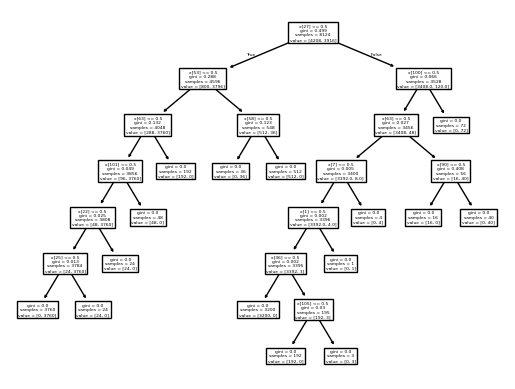

In [52]:
# print tree
plot_tree(dtree)

## Before You Submit...

00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.